# Fabey Perot in meep(AB)

## first of all load the library

In [1]:
import meep as mp
import numpy as np
import matplotlib.pyplot as plt

## 定義參數

In [2]:
fmin = 1 #300THz
fmax = 2 #600THz
nf = 1000 
fcen = (fmin + fmax)/2
df = fmax - fmin
dfp = 1/2
fre = np.linspace(fmin,fmax,nf)
omega = 2 * np.pi * fre

In [3]:
dpml = 1

dA = 2
dB = 3
epsilonA = 12
epsilonB = 3

NAB = 1

sz = 2*dpml+(dA+dB)*NAB

resolution = 100 # pixels/μm

cell_size = mp.Vector3(z=sz)

pml_layers = [mp.PML(thickness=dpml)]

source_z=-sz/2+dpml
flux_reg_z=sz/2-dpml

## geometry AB and BA

In [4]:
def BlockAB(N, center):
    geometry = []
    for i in range(N):
        geometry = np.append(geometry, mp.Block(mp.Vector3(mp.inf,mp.inf,dA),
                     center=mp.Vector3(z=center-(dA+dB)*N/2 + (dA+dB)*i + dA/2),
                     material=mp.Medium(epsilon=epsilonA)))
        geometry = np.append(geometry, mp.Block(mp.Vector3(mp.inf,mp.inf,dB),
                     center=mp.Vector3(z=center-(dA+dB)*N/2 + (dA+dB)*i + dA + dB/2),
                     material=mp.Medium(epsilon=epsilonB)))
    geometry = geometry.tolist()
    return geometry

## Sources set up

In [5]:
sources = [mp.Source(mp.GaussianSource(fcen,fwidth=df),
                     component=mp.Ex,
                     center=mp.Vector3(z=source_z),
                     size=mp.Vector3())]

## Simulation 真空

In [6]:
sim_vac = mp.Simulation(cell_size=cell_size,
                    resolution=resolution,
                    boundary_layers=pml_layers,
                    dimensions=1,
                    sources=sources)
refl_fr = mp.FluxRegion(center=mp.Vector3(z=-flux_reg_z))
refl = sim_vac.add_flux(fcen, df*dfp,nf, refl_fr)
tran_fr = mp.FluxRegion(center=mp.Vector3(z=flux_reg_z))
tran = sim_vac.add_flux(fcen, df*dfp, nf, tran_fr)
sim_vac.run(until_after_sources=mp.stop_when_fields_decayed(50,mp.Ex,
                                                            mp.Vector3(z=0),1e-3))
vac_flux = mp.get_fluxes(tran)
flux_freqs = mp.get_flux_freqs(tran)


-----------
Initializing structure...
time for choose_chunkdivision = 6.58035e-05 s
Working in 1D dimensions.
Computational cell is 0 x 0 x 7 with resolution 100
time for set_epsilon = 0.00024581 s
-----------
field decay(t = 50.005): 0.25045617925549085 / 0.25045617925549085 = 1.0
field decay(t = 100.01): 5.779517299904156e-16 / 0.25045617925549085 = 2.30759620987768e-15
run 0 finished at t = 100.01 (20002 timesteps)


## Simulation 介質AB

In [7]:
sim = mp.Simulation(cell_size=cell_size,
                    resolution=resolution,
                    boundary_layers=pml_layers,
                    sources=sources,
                    dimensions=1,
                    geometry=BlockAB(NAB,0))
refl_fr = mp.FluxRegion(center=mp.Vector3(z=-flux_reg_z))
refl = sim_vac.add_flux(fcen, df*dfp,nf, refl_fr)
tran_fr = mp.FluxRegion(center=mp.Vector3(z=flux_reg_z))
tran = sim.add_flux(fcen, df*dfp, nf, tran_fr)
sim.run(until_after_sources=mp.stop_when_fields_decayed(50,mp.Ex,
                                                        mp.Vector3(z=0),1e-3))
tran_flux = mp.get_fluxes(tran)
refl_flux = mp.get_fluxes(refl)

-----------
Initializing structure...
time for choose_chunkdivision = 6.79493e-05 s
Working in 1D dimensions.
Computational cell is 0 x 0 x 7 with resolution 100
     block, center = (0,0,-1.5)
          size (1e+20,1e+20,2)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (0,0,1)
          size (1e+20,1e+20,3)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3,3,3)
time for set_epsilon = 0.000339031 s
-----------
field decay(t = 50.005): 0.0901553138244702 / 0.0901553138244702 = 1.0
field decay(t = 100.01): 0.0001668906751140258 / 0.0901553138244702 = 0.0018511462944819552
field decay(t = 150.01500000000001): 6.956541770148884e-08 / 0.0901553138244702 = 7.716174981868591e-07
run 0 finished at t = 150.01500000000001 (30003 timesteps)


In [8]:
wvls = np.empty(nf)
R = np.empty(nf)
T = np.empty(nf)
for i in range(nf):
        wvls[i] = 1/flux_freqs[i]
        R[i] = -refl_flux[i]/vac_flux[i]
        T[i] = tran_flux[i]/vac_flux[i]

/home/mark/anaconda3/envs/mp/lib/python3.10/site-packages/numpy/core/getlimits.py:499: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/mark/anaconda3/envs/mp/lib/python3.10/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)


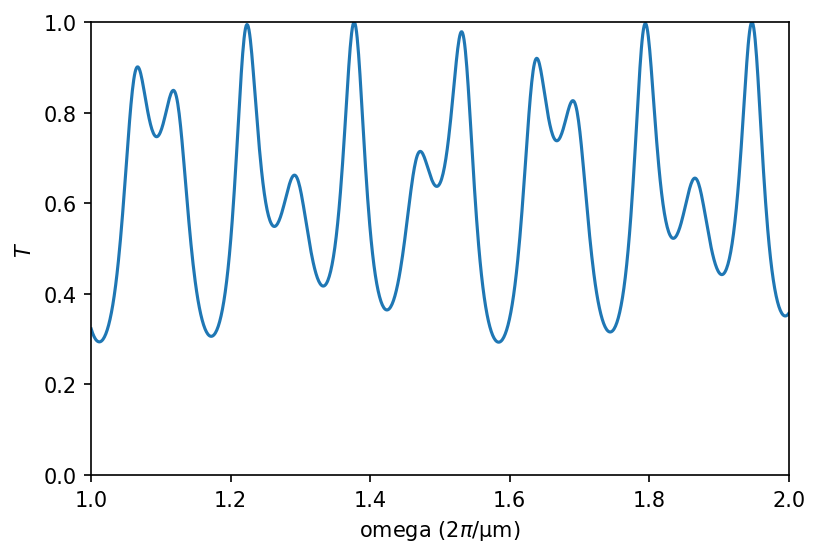

In [9]:
plt.figure(dpi=150)#解析度
plt.plot(omega/2/np.pi,T,'-',label='$T_{nur}$')#x軸omega y軸T 
plt.xlabel("omega ($2\pi$/μm)")
plt.ylabel("$T$")
plt.xlim([fmin,fmax])
plt.ylim([0,1])
plt.savefig('AB.png')
plt.show()